## Import Libary

In [1]:
import numpy as np
import pandas as pd
import numba.cuda as cuda
from numba import njit, prange, jit
from sklearn.preprocessing import StandardScaler

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import matplotlib
matplotlib.rc('figure', figsize=(10, 5))

## Read Data

In [2]:
df_data = pd.read_csv('./CC GENERAL.csv')
df_data = df_data.drop('CUST_ID', axis=1)

In [3]:
def highlight_minimum_time(s):
    is_min = s == s.min()
    return ['background-color: yellow' if v else '' for v in is_min]

## EDA

### Data description

In [4]:
df_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8950 entries, 0 to 8949
Data columns (total 17 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   BALANCE                           8950 non-null   float64
 1   BALANCE_FREQUENCY                 8950 non-null   float64
 2   PURCHASES                         8950 non-null   float64
 3   ONEOFF_PURCHASES                  8950 non-null   float64
 4   INSTALLMENTS_PURCHASES            8950 non-null   float64
 5   CASH_ADVANCE                      8950 non-null   float64
 6   PURCHASES_FREQUENCY               8950 non-null   float64
 7   ONEOFF_PURCHASES_FREQUENCY        8950 non-null   float64
 8   PURCHASES_INSTALLMENTS_FREQUENCY  8950 non-null   float64
 9   CASH_ADVANCE_FREQUENCY            8950 non-null   float64
 10  CASH_ADVANCE_TRX                  8950 non-null   int64  
 11  PURCHASES_TRX                     8950 non-null   int64  
 12  CREDIT

In [5]:
df_data.describe()

,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE
count,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8949.000000,8950.000000,8637.000000,8950.000000,8950.000000
mean,1564.474828,0.877271,1003.204834,592.437371,411.067645,978.871112,0.490351,0.202458,0.364437,0.135144,3.248827,14.709832,4494.449450,1733.143852,864.206542,0.153715,11.517318
std,2081.531879,0.236904,2136.634782,1659.887917,904.338115,2097.163877,0.401371,0.298336,0.397448,0.200121,6.824647,24.857649,3638.815725,2895.063757,2372.446607,0.292499,1.338331
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,50.000000,0.000000,0.019163,0.000000,6.000000
25%,128.281915,0.888889,39.635000,0.000000,0.000000,0.000000,0.083333,0.000000,0.000000,0.000000,0.000000,1.000000,1600.000000,383.276166,169.123707,0.000000,12.000000
50%,873.385231,1.000000,361.280000,38.000000,89.000000,0.000000,0.500000,0.083333,0.166667,0.000000,0.000000,7.000000,3000.000000,856.901546,312.343947,0.000000,12.000000
75%,2054.140036,1.000000,1110.130000,577.405000,468.637500,1113.821139,0.916667,0.300000,0.750000,0.222222,4.000000,17.000000,6500.000000,1901.134317,825.485459,0.142857,12.000000
max,19043.138560,1.000000,49039.570000,40761.250000,22500.000000,47137.211760,1.000000,1.000000,1.000000,1.500000,123.000000,358.000000,30000.000000,50721.483360,76406.207520,1.000000,12.000000


### Correlation matrix

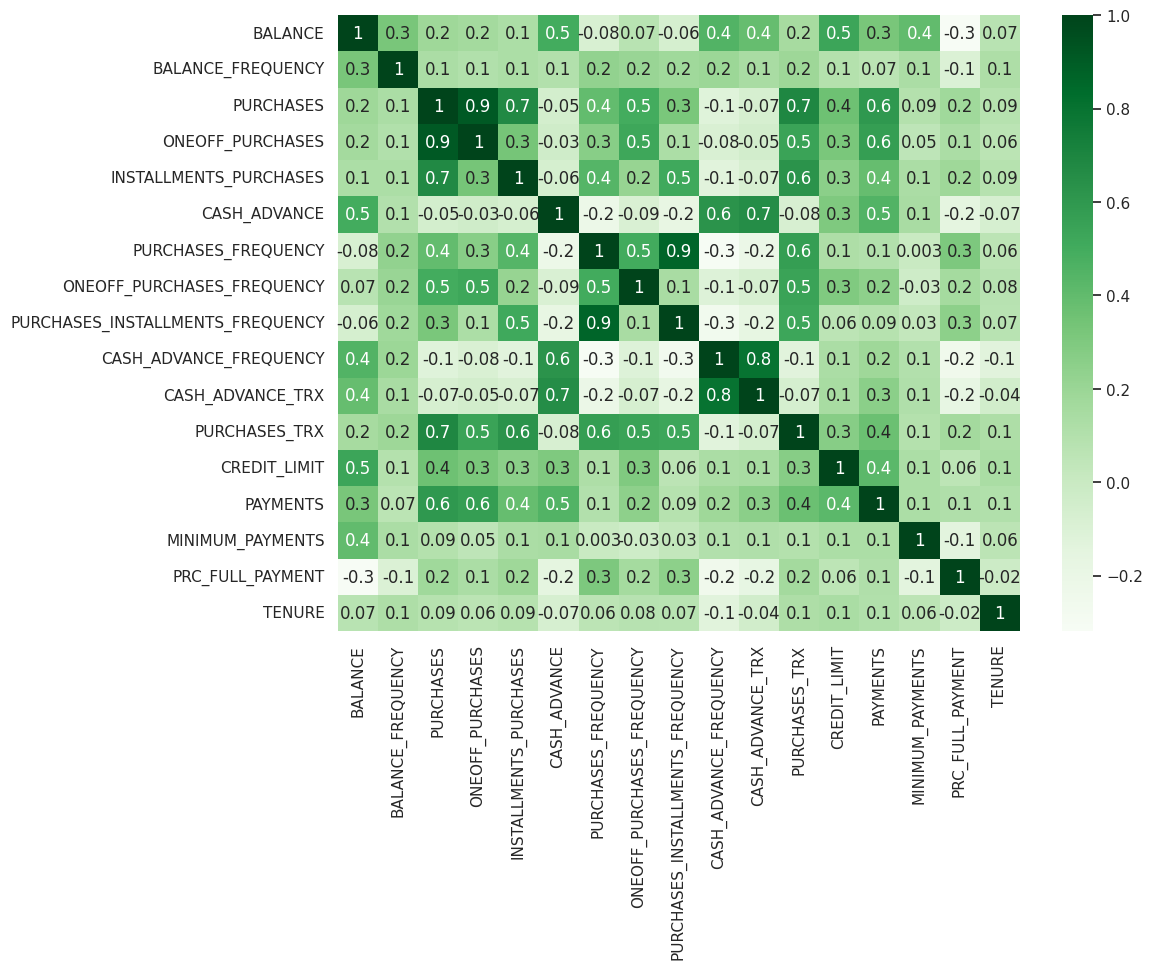

In [6]:
corr = df_data.corr()
plt.figure(figsize=(11,8))
sns.heatmap(corr, cmap="Greens",annot=True, fmt='.1g')
plt.show()

### Feature Selection

In [7]:
features = ['BALANCE', 'CASH_ADVANCE','PURCHASES', 'ONEOFF_PURCHASES', \
            'INSTALLMENTS_PURCHASES', 'ONEOFF_PURCHASES_FREQUENCY', \
            'PURCHASES_TRX', 'PAYMENTS', 'CASH_ADVANCE_FREQUENCY',
            'CASH_ADVANCE_TRX', 'PURCHASES_FREQUENCY']
df_data = df_data[features]
df_data_np = df_data.to_numpy()

## Preprocessing

### Fill missing value

#### Fill missing CPU

In [8]:
@njit(parallel=False)
def fill_missing_org(df):
    n = df.shape[1]
    res = np.empty_like(df, dtype=np.float64)

    for i in range(n):
        data_i = df[:, i]
        res[:, i] = data_i.copy()
        mean_data_i = np.nanmean(data_i)

        inds = np.where(np.isnan(data_i))
        res[inds[0], i] = mean_data_i

    return res

#### Fill missing CPU Parallel

In [9]:
@jit(nopython=True, parallel=True)
def fill_missing_parallel(df):
    n = df.shape[1]
    res = np.empty_like(df, dtype=np.float64)

    for i in prange(n):
        data_i = df[:, i]
        res[:, i] = data_i.copy()
        mean_data_i = np.nanmean(data_i)

        inds = np.where(np.isnan(data_i))
        res[inds[0], i] = mean_data_i

    return res

#### Expected result using Numpy

In [10]:
df_np_exp = df_data_np.copy()

#Obtain mean of columns as you need, nanmean is convenient.
col_mean = np.nanmean(df_np_exp, axis=0)
print(col_mean)

#Find indices that you need to replace
inds = np.where(np.isnan(df_np_exp))

#Place column means in the indices. Align the arrays using take
df_np_exp[inds] = np.take(col_mean, inds[1])

[1.56447483e+03 9.78871112e+02 1.00320483e+03 5.92437371e+02
 4.11067645e+02 2.02457684e-01 1.47098324e+01 1.73314385e+03
 1.35144200e-01 3.24882682e+00 4.90350548e-01]


#### Output result running by CPU

In [11]:
output_fill_missing_org = fill_missing_org(df_data_np)

#### Comparasion diff

In [12]:
output_fill_missing_org - df_np_exp

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

#### Output result running by CPU Parallel

In [13]:
output_fill_missing_parallel = fill_missing_parallel(df_data_np)

#### Comparasion diff

In [14]:
output_fill_missing_parallel - df_np_exp

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

### Measure running time with different strategies

#### Measure time with running with increasing number of columns

In [15]:
res = []
multiples = range(1, 30, 4)

for idx, i in enumerate(multiples):
    data = np.tile(df_data_np, i)
    data_clone = data.copy()

    o_1 = %timeit -o -q col_mean = np.nanmean(data, axis=0); inds = np.where(np.isnan(data)); data_clone[inds] = np.take(col_mean, inds[1])
    o_2 = %timeit -o -q fill_missing_org(data)
    o_3 = %timeit -o -q fill_missing_parallel(data)

    res.append((data.shape[1], o_1.best, o_2.best, o_3.best))
    print('{0} of {1} complete {2}'.format(idx + 1, len(multiples), data.shape))

1 of 8 complete (8950, 11)
2 of 8 complete (8950, 55)
3 of 8 complete (8950, 99)
4 of 8 complete (8950, 143)
5 of 8 complete (8950, 187)
6 of 8 complete (8950, 231)
7 of 8 complete (8950, 275)
8 of 8 complete (8950, 319)


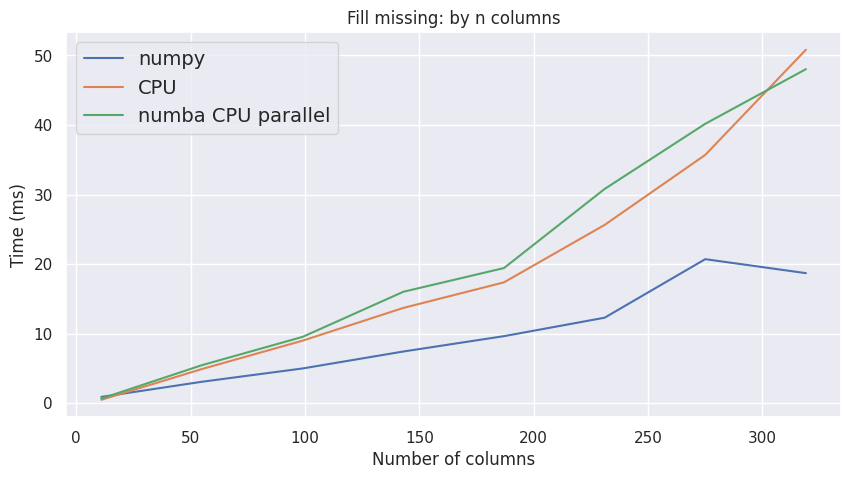

In [16]:
df_viz = pd.DataFrame(res, columns = ['num_cols', 'numpy', 'CPU', 'numba CPU parallel'])

df_viz = df_viz.set_index('num_cols')
df_viz = df_viz.apply(lambda x: 1000 * x)

ax = df_viz.plot()
ax.set_title('Fill missing: by n columns')
ax.set_xlabel('Number of columns')
ax.set_ylabel('Time (ms)')
plt.legend(prop={'size': 14})

#### Table measuring strategies check time

In [17]:
df_viz.style.apply(highlight_minimum_time, axis=1)

,numpy,CPU,numba CPU parallel
num_cols,,,
11,0.902600,0.493311,0.663084
55,3.081820,4.913859,5.470095
99,4.994597,8.989727,9.535741
143,7.428940,13.696174,16.018220
187,9.638602,17.373335,19.429562
231,12.288733,25.632561,30.800493
275,20.709681,35.701379,40.174529
319,18.699041,50.823128,48.031984


#### Measure time with running with increasing number of row

In [18]:
res = []

for idx, i in enumerate(multiples):
    data = np.tile(df_data_np.T, i).T
    data_clone = data.copy()

    o_1 = %timeit -o -q col_mean = np.nanmean(data, axis=0); inds = np.where(np.isnan(data)); data_clone[inds] = np.take(col_mean, inds[1])
    o_2 = %timeit -o -q fill_missing_org(data)
    o_3 = %timeit -o -q fill_missing_parallel(data)

    res.append((data.shape[0], o_1.best, o_2.best, o_3.best))
    print('{0} of {1} complete {2}'.format(idx + 1, len(multiples), data.shape))

1 of 8 complete (8950, 11)
2 of 8 complete (44750, 11)
3 of 8 complete (80550, 11)
4 of 8 complete (116350, 11)
5 of 8 complete (152150, 11)
6 of 8 complete (187950, 11)
7 of 8 complete (223750, 11)
8 of 8 complete (259550, 11)


In [19]:
df_viz = pd.DataFrame(res, columns = ['num_rows', 'numpy', 'CPU', 'numba CPU parallel'])
df_viz = df_viz.set_index('num_rows')
df_viz = df_viz.apply(lambda x: 1000 * x)

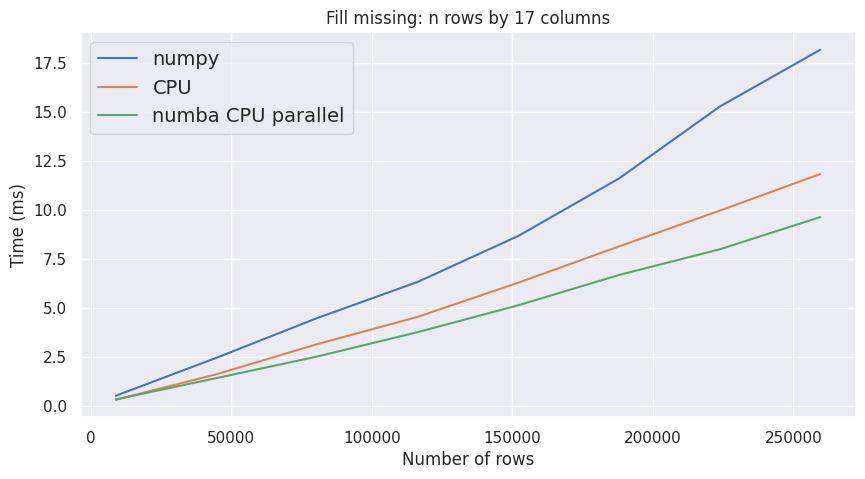

In [20]:
ax = df_viz.plot()
ax.set_title('Fill missing: n rows by 17 columns')
ax.set_xlabel('Number of rows')
ax.set_ylabel('Time (ms)')
plt.legend(prop={'size': 14})

#### Table measuring strategies check time

In [21]:
df_viz.style.apply(highlight_minimum_time, axis=1)

,numpy,CPU,numba CPU parallel
num_rows,,,
8950,0.528928,0.327102,0.342832
44750,2.466582,1.626408,1.432070
80550,4.492896,3.160990,2.529935
116350,6.339500,4.557589,3.776878
152150,8.686723,6.300764,5.148665
187950,11.616548,8.150907,6.692285
223750,15.282975,9.974796,8.001870
259550,18.186986,11.845110,9.647857


### Standardization

#### Standard CPU

In [22]:
@njit(parallel=False)
def standard_org(df):
    n = df.shape[1]
    res = np.empty_like(df, dtype=np.float64)

    for i in range(n):
        data_i = df[:, i]
        res[:, i] = (data_i - np.mean(data_i)) / np.std(data_i)

    return res

#### Standard CPU Parallel

In [23]:
@jit(nopython=True, parallel=True)
def standard_parallel(df):
    n = df.shape[1]
    res = np.empty_like(df, dtype=np.float64)

    for i in prange(n):
        data_i = df[:, i]
        res[:, i] = (data_i - np.mean(data_i)) / np.std(data_i)

    return res

#### Expected result using Sklearn

In [24]:
sklearn_std_expected = StandardScaler().fit_transform(df_data_np)

#### Output result running by CPU

In [25]:
output_std_org = standard_org(df_data_np)

#### Comparasion diff

In [26]:
output_std_org - sklearn_std_expected

array([[-1.66533454e-15, -1.94289029e-14, -1.08246745e-14, ...,
        -2.72004641e-14, -8.65973959e-15,  2.48689958e-14],
       [-1.33226763e-15,  1.08357767e-13, -1.18238752e-14, ...,
         8.10462808e-15,  2.01227923e-15,  3.79696274e-14],
       [-1.44328993e-15, -1.94289029e-14, -3.89965837e-15, ...,
        -2.72004641e-14, -8.65973959e-15, -4.08562073e-14],
       ...,
       [-1.77635684e-15, -1.94289029e-14, -1.03250741e-14, ...,
        -2.72004641e-14, -8.65973959e-15, -2.77555756e-14],
       [-1.66533454e-15, -1.87072580e-14, -1.18238752e-14, ...,
        -3.71924713e-15, -3.33066907e-15,  3.79696274e-14],
       [-1.66533454e-15, -1.69309011e-14, -6.17561557e-16, ...,
         1.98729921e-14, -3.33066907e-15, -1.45994328e-14]])

#### Output result running by CPU Parallel

In [27]:
output_std_parallel = standard_parallel(df_data_np)

#### Comparasion diff

In [28]:
output_std_parallel - sklearn_std_expected

array([[-1.66533454e-15, -1.94289029e-14, -1.08246745e-14, ...,
        -2.72004641e-14, -8.65973959e-15,  2.48689958e-14],
       [-1.33226763e-15,  1.08357767e-13, -1.18238752e-14, ...,
         8.10462808e-15,  2.01227923e-15,  3.79696274e-14],
       [-1.44328993e-15, -1.94289029e-14, -3.89965837e-15, ...,
        -2.72004641e-14, -8.65973959e-15, -4.08562073e-14],
       ...,
       [-1.77635684e-15, -1.94289029e-14, -1.03250741e-14, ...,
        -2.72004641e-14, -8.65973959e-15, -2.77555756e-14],
       [-1.66533454e-15, -1.87072580e-14, -1.18238752e-14, ...,
        -3.71924713e-15, -3.33066907e-15,  3.79696274e-14],
       [-1.66533454e-15, -1.69309011e-14, -6.17561557e-16, ...,
         1.98729921e-14, -3.33066907e-15, -1.45994328e-14]])

### Measure running time with different strategies

#### Measure time with running with increasing number of columns

In [29]:
res = []
multiples = range(1, 30, 4)

for idx, i in enumerate(multiples):
    data = np.tile(df_data_np, i)

    o_1 = %timeit -o -q StandardScaler().fit_transform(data)
    o_2 = %timeit -o -q standard_org(data)
    o_3 = %timeit -o -q standard_parallel(data)

    res.append((data.shape[1], o_1.best, o_2.best, o_3.best))
    print('{0} of {1} complete {2}'.format(idx + 1, len(multiples), data.shape))

1 of 8 complete (8950, 11)
2 of 8 complete (8950, 55)
3 of 8 complete (8950, 99)
4 of 8 complete (8950, 143)
5 of 8 complete (8950, 187)
6 of 8 complete (8950, 231)
7 of 8 complete (8950, 275)
8 of 8 complete (8950, 319)


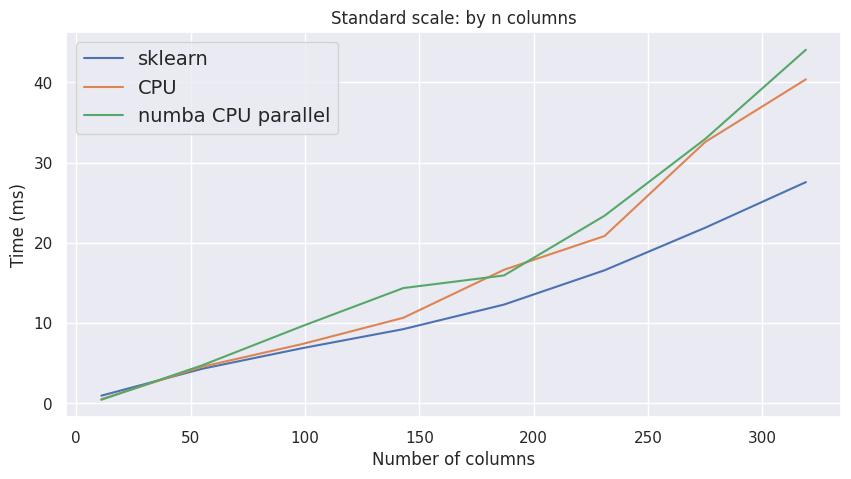

In [30]:
df_viz = pd.DataFrame(res, columns = ['num_cols', 'sklearn', 'CPU', 'numba CPU parallel'])

df_viz = df_viz.set_index('num_cols')
df_viz = df_viz.apply(lambda x: 1000 * x)

ax = df_viz.plot()
ax.set_title('Standard scale: by n columns')
ax.set_xlabel('Number of columns')
ax.set_ylabel('Time (ms)')
plt.legend(prop={'size': 14})

#### Table measuring strategies check time

In [31]:
df_viz.style.apply(highlight_minimum_time, axis=1)

,sklearn,CPU,numba CPU parallel
num_cols,,,
11,0.968273,0.526045,0.460690
55,4.316844,4.570662,4.742965
99,6.896527,7.415107,9.655794
143,9.258259,10.674223,14.376080
187,12.317051,16.652449,15.949113
231,16.594492,20.862532,23.392957
275,21.899846,32.584309,32.962929
319,27.580581,40.384213,44.072575


#### Measure time with running with increasing number of row

In [32]:
res = []

for idx, i in enumerate(multiples):
    data = np.tile(df_data_np.T, i).T
    o_1 = %timeit -o -q StandardScaler().fit_transform(data)
    o_2 = %timeit -o -q standard_org(data)
    o_3 = %timeit -o -q standard_parallel(data)

    res.append((data.shape[0], o_1.best, o_2.best, o_3.best))
    print('{0} of {1} complete {2}'.format(idx + 1, len(multiples), data.shape))

1 of 8 complete (8950, 11)
2 of 8 complete (44750, 11)
3 of 8 complete (80550, 11)
4 of 8 complete (116350, 11)
5 of 8 complete (152150, 11)
6 of 8 complete (187950, 11)
7 of 8 complete (223750, 11)
8 of 8 complete (259550, 11)


In [33]:
df_viz = pd.DataFrame(res, columns = ['num_rows', 'sklearn', 'CPU', 'numba CPU parallel'])
df_viz = df_viz.set_index('num_rows')
df_viz = df_viz.apply(lambda x: 1000 * x)

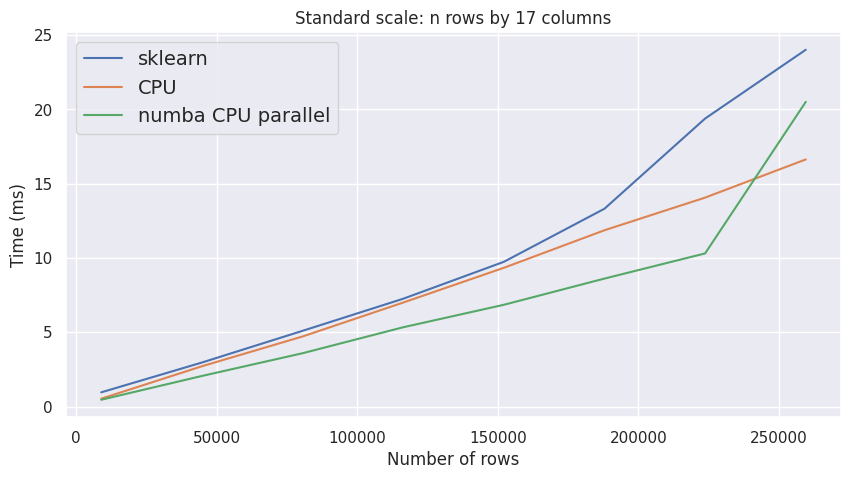

In [34]:
ax = df_viz.plot()
ax.set_title('Standard scale: n rows by 17 columns')
ax.set_xlabel('Number of rows')
ax.set_ylabel('Time (ms)')
plt.legend(prop={'size': 14})

#### Table measuring strategies check time

In [35]:
df_viz.style.apply(highlight_minimum_time, axis=1)

,sklearn,CPU,numba CPU parallel
num_rows,,,
8950,0.963003,0.534848,0.463974
44750,2.968152,2.717187,2.064111
80550,5.101395,4.720949,3.594066
116350,7.260991,7.004822,5.342063
152150,9.745039,9.342371,6.854266
187950,13.319623,11.870526,8.618527
223750,19.388619,14.067077,10.312364
259550,24.017758,16.636613,20.509787


### GPU

#### Fill missing value

In [36]:
from numba import cuda
import numpy as np

def fill_missing_cpu(df):
    imputed_df = df.copy()

    for j in range(imputed_df.shape[1]):
        mean_data_j = np.nanmean(imputed_df[:, j])

        for i in range(imputed_df.shape[0]):
            if np.isnan(imputed_df[i, j]):
                imputed_df[i, j] = mean_data_j

    return imputed_df

@cuda.jit
def parallel_fill_gpu(df, result):
    i, j = cuda.grid(2)
    if i < df.shape[0] and j < df.shape[1]:
        result[i, j] = df[i, j]

def fill_missing_parallel_gpu(df):
    n_rows, n_cols = df.shape
    threads_per_block = (16, 16)
    blocks_per_grid_x = (n_rows + threads_per_block[0] - 1) // threads_per_block[0]
    blocks_per_grid_y = (n_cols + threads_per_block[1] - 1) // threads_per_block[1]
    blocks_per_grid = (blocks_per_grid_x, blocks_per_grid_y)

    # Impute missing values on CPU
    imputed_df = fill_missing_cpu(df)

    d_imputed_df = cuda.to_device(imputed_df)
    d_result = cuda.device_array_like(d_imputed_df)

    parallel_fill_gpu[blocks_per_grid, threads_per_block](d_imputed_df, d_result)

    result = d_result.copy_to_host()
    return result


#### Standardization

In [37]:
import numpy as np
import math
import numba.cuda as cuda

@cuda.jit
def standard_gpu(df, result):
    i, j = cuda.grid(2)
    if i < df.shape[0] and j < df.shape[1]:
        data_ij = df[i, j]
        mean_data_j = 0.0
        std_data_j = 0.0
        count = 0

        for k in range(df.shape[0]):
            data_kj = df[k, j]
            if not (data_kj != data_kj):  # Check for NaN
                mean_data_j += data_kj
                std_data_j += data_kj ** 2
                count += 1

        if count > 0:
            mean_data_j /= count
            std_data_j = math.sqrt((std_data_j / count) - (mean_data_j ** 2))

            if not (data_ij != data_ij):  # Check for NaN
                result[i, j] = (data_ij - mean_data_j) / std_data_j

def standard_parallel_gpu(df):
    n_rows, n_cols = df.shape
    threads_per_block = (16, 16)
    blocks_per_grid_x = (n_rows + threads_per_block[0] - 1) // threads_per_block[0]
    blocks_per_grid_y = (n_cols + threads_per_block[1] - 1) // threads_per_block[1]
    blocks_per_grid = (blocks_per_grid_x, blocks_per_grid_y)

    d_df = cuda.to_device(df)
    d_result = cuda.device_array_like(d_df)

    standard_gpu[blocks_per_grid, threads_per_block](d_df, d_result)

    result = d_result.copy_to_host()
    return result


In [38]:
df_data_np = df_data.to_numpy()

In [39]:
standard_parallel_gpu(df_data_np)

array([[-0.73198937, -0.46678555, -0.42489974, ..., -0.67534886,
        -0.47606982, -0.80649035],
       [ 0.78696085,  2.60560451, -0.46955188, ...,  0.57396272,
         0.11007385, -1.22175806],
       [ 0.44713513, -0.46678555, -0.10766823, ..., -0.67534886,
        -0.47606982,  1.26984323],
       ...,
       [-0.7403981 , -0.46678555, -0.40196519, ..., -0.67534886,
        -0.47606982,  0.85457552],
       [-0.74517423, -0.4493521 , -0.46955188, ...,  0.15752719,
        -0.18299798, -1.22175806],
       [-0.57257511, -0.40620512,  0.04214581, ...,  0.99039825,
        -0.18299798,  0.4393103 ]])

In [40]:
fill_missing_parallel_gpu(df_data_np)

array([[4.09007490e+01, 0.00000000e+00, 9.54000000e+01, ...,
        0.00000000e+00, 0.00000000e+00, 1.66667000e-01],
       [3.20246742e+03, 6.44294548e+03, 0.00000000e+00, ...,
        2.50000000e-01, 4.00000000e+00, 0.00000000e+00],
       [2.49514886e+03, 0.00000000e+00, 7.73170000e+02, ...,
        0.00000000e+00, 0.00000000e+00, 1.00000000e+00],
       ...,
       [2.33986730e+01, 0.00000000e+00, 1.44400000e+02, ...,
        0.00000000e+00, 0.00000000e+00, 8.33333000e-01],
       [1.34575640e+01, 3.65587780e+01, 0.00000000e+00, ...,
        1.66667000e-01, 2.00000000e+00, 0.00000000e+00],
       [3.72708075e+02, 1.27040008e+02, 1.09325000e+03, ...,
        3.33333000e-01, 2.00000000e+00, 6.66667000e-01]])

### Measure running time with different strategies

#### Measure time with running with increasing number of columns

In [41]:
res = []
multiples = range(1, 30, 4)

for idx, i in enumerate(multiples):
    data = np.tile(df_data_np, i)

    o_1 = %timeit -o -q StandardScaler().fit_transform(data)
    o_2 = %timeit -o -q standard_parallel_gpu(df_data_np)
    o_3 = %timeit -o -q fill_missing_parallel_gpu(df_data_np)

    res.append((data.shape[1], o_1.best, o_2.best, o_3.best))
    print('{0} of {1} complete {2}'.format(idx + 1, len(multiples), data.shape))

1 of 8 complete (8950, 11)
2 of 8 complete (8950, 55)
3 of 8 complete (8950, 99)
4 of 8 complete (8950, 143)
5 of 8 complete (8950, 187)
6 of 8 complete (8950, 231)
7 of 8 complete (8950, 275)
8 of 8 complete (8950, 319)


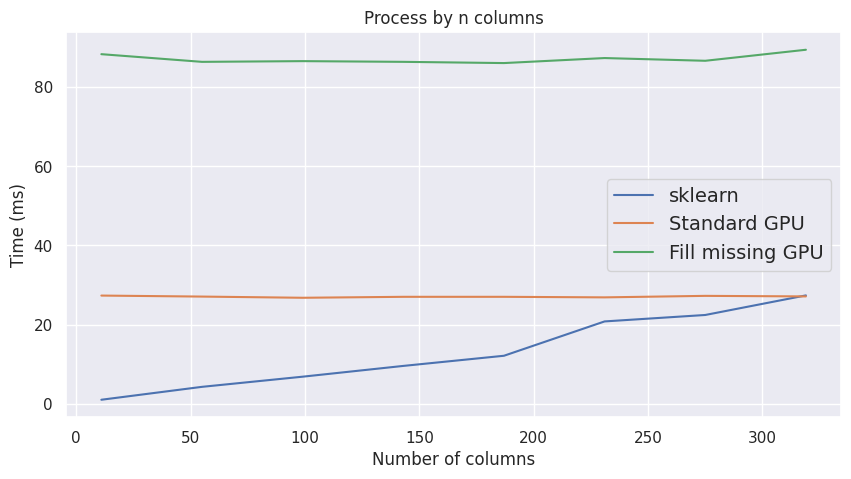

In [42]:
df_viz = pd.DataFrame(res, columns = ['num_cols', 'sklearn', 'Standard GPU', 'Fill missing GPU'])

df_viz = df_viz.set_index('num_cols')
df_viz = df_viz.apply(lambda x: 1000 * x)

ax = df_viz.plot()
ax.set_title('Process by n columns')
ax.set_xlabel('Number of columns')
ax.set_ylabel('Time (ms)')
plt.legend(prop={'size': 14})

#### Measure time with running with increasing number of row

In [43]:
res = []

for idx, i in enumerate(multiples):
    data = np.tile(df_data_np.T, i).T
    o_1 = %timeit -o -q StandardScaler().fit_transform(data)
    o_2 = %timeit -o -q standard_org(data)
    o_3 = %timeit -o -q standard_parallel(data)

    res.append((data.shape[0], o_1.best, o_2.best, o_3.best))
    print('{0} of {1} complete {2}'.format(idx + 1, len(multiples), data.shape))

1 of 8 complete (8950, 11)
2 of 8 complete (44750, 11)
3 of 8 complete (80550, 11)
4 of 8 complete (116350, 11)
5 of 8 complete (152150, 11)
6 of 8 complete (187950, 11)
7 of 8 complete (223750, 11)
8 of 8 complete (259550, 11)


In [44]:
df_viz = pd.DataFrame(res, columns = ['num_rows', 'sklearn', 'Standard GPU', 'Fill missing GPU'])
df_viz = df_viz.set_index('num_rows')
df_viz = df_viz.apply(lambda x: 1000 * x)

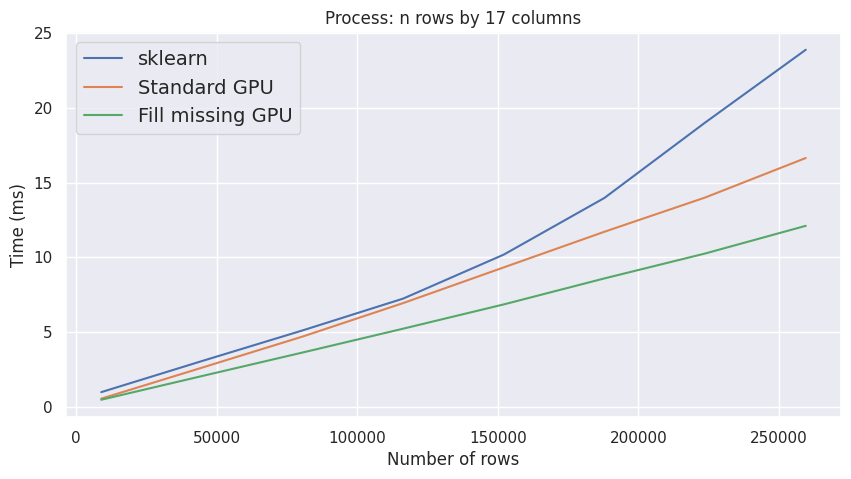

In [45]:
ax = df_viz.plot()
ax.set_title('Process: n rows by 17 columns')
ax.set_xlabel('Number of rows')
ax.set_ylabel('Time (ms)')
plt.legend(prop={'size': 14})